# Example of Naive Bayes decoder

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing that is different for the Naive Bayes decoder, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files
Note that you may need to specify the path below

In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import sys
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import NaiveBayesDecoder

Using TensorFlow backend.


## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=0&preview=example_data_hc.pickle). 

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [2]:
folder='../crcns/' #ENTER THE FOLDER THAT YOUR DATA IS IN

with open(folder+'example_data_hc.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f,encoding='latin1') #If using python 3
#     neural_data,pos_binned=pickle.load(f)
    
# #If you would prefer to load the '.h5' example file rather than the '.pickle' example file.
# data=dd.io.load(folder+'example_data_hc.h5')
# neural_data=data['neural_data']
# pos_binned=data['pos_binned']

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [3]:
bins_before=8#How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=9 #How many bins of neural data after the output are used for decoding

### 3B. Format Covariates

#### Format Input

In [4]:
#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0) #Total number of spikes of each neuron
rmv_nrn=np.where(nd_sum<100) #Find neurons who have less than 100 spikes total
neural_data=np.delete(neural_data,rmv_nrn,1) #Remove those neurons
X=neural_data

#### Format Output

In [5]:
#Set decoding output
y=pos_binned

### 3C. More formatting

In [6]:
#Number of bins to sum spikes over
N=bins_before+bins_current+bins_after 

In [7]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
y=np.delete(y,rmv_time,0)

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [8]:
#Set what part of data should be part of the training/testing/validation sets

training_range=[0, 0.5]
valid_range=[0.5,0.65]
testing_range=[0.65, 0.8]

### Split Data: For Naive Bayes

In [9]:
#Number of examples after taking into account bins removed for lag alignment
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:]
y_valid=y[valid_set,:]

### Combine data across specified bins
Get total number of spikes across "bins_before","bins_current",and "bins_after"



In [10]:
#Initialize matrices for neural data in Naive bayes format
num_nrns=X_train.shape[1]
X_b_train=np.empty([X_train.shape[0]-N+1,num_nrns])
X_b_valid=np.empty([X_valid.shape[0]-N+1,num_nrns])
X_b_test=np.empty([X_test.shape[0]-N+1,num_nrns])

#Below assumes that bins_current=1 (otherwise alignment will be off by 1 between the spikes and outputs)

#For all neurons, within all the bins being used, get the total number of spikes (sum across all those bins)
#Do this for the training/validation/testing sets
for i in range(num_nrns):
    X_b_train[:,i]=N*np.convolve(X_train[:,i], np.ones((N,))/N, mode='valid') #Convolving w/ ones is a sum across those N bins
    X_b_valid[:,i]=N*np.convolve(X_valid[:,i], np.ones((N,))/N, mode='valid')
    X_b_test[:,i]=N*np.convolve(X_test[:,i], np.ones((N,))/N, mode='valid')

#Make integer format
X_b_train=X_b_train.astype(int)
X_b_valid=X_b_valid.astype(int)
X_b_test=X_b_test.astype(int)

#Make y's aligned w/ X's
#e.g. we have to remove the first y if we are using 1 bin before, and have to remove the last y if we are using 1 bin after
if bins_before>0 and bins_after>0:
    y_train=y_train[bins_before:-bins_after,:]
    y_valid=y_valid[bins_before:-bins_after,:]
    y_test=y_test[bins_before:-bins_after,:]
    
if bins_before>0 and bins_after==0:
    y_train=y_train[bins_before:,:]
    y_valid=y_valid[bins_before:,:]
    y_test=y_test[bins_before:,:]

In [11]:
X_b_train.shape

(13893, 46)

(0, 500)

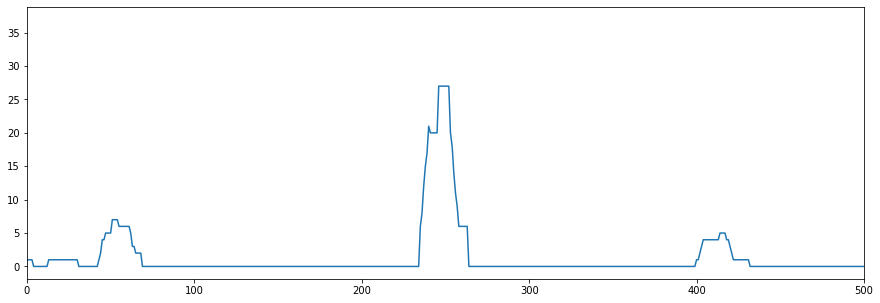

In [12]:
figure = plt.figure(figsize=(15,5))
ax = figure.add_subplot(111)
ax.plot(X_b_train[:,10])
ax.set_xlim(0,500)

## 4. Run Decoder
Note that in this example, we are evaluating the model fit on the validation set

In [13]:
#Declare model

#The parameter "encoding_model" can either be linear or quadratic, although additional encoding models could later be added.

#The parameter "res" is the number of bins used (resolution) for decoding predictions
#So if res=100, we create a 100 x 100 grid going from the minimum to maximum of the output variables (x and y positions)
#The prediction the decoder makes will be a value on that grid 

model_nb=NaiveBayesDecoder(encoding_model='linear',res=80)

#Fit model
model_nb.fit(X_b_train,y_train)

In [14]:
#Get predictions
y_valid_predicted=model_nb.predict(X_b_valid,y_valid)

/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/Neural_Decoding-0.1.2.dev0-py3.6.egg/Neural_Decoding/decoders.py:986: RuntimeWarning: overflow encountered in power
/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/Neural_Decoding-0.1.2.dev0-py3.6.egg/Neural_Decoding/decoders.py:989: RuntimeWarning: invalid value encountered in multiply


In [15]:
#Get metric of fit
R2_nb=get_R2(y_valid,y_valid_predicted)
print(R2_nb)

[0.02607672 0.54104384]


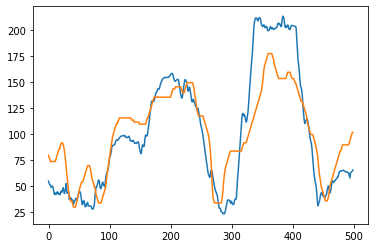

In [16]:
#Make example plot
plt.plot(y_valid[2000:2500,1])
plt.plot(y_valid_predicted[2000:2500,1])

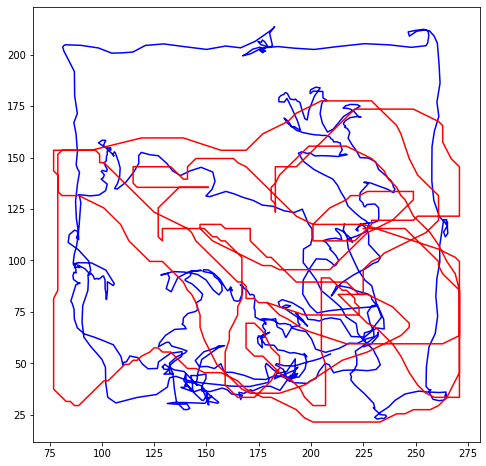

In [17]:
fig_x_dnn=plt.figure(figsize=(8,8))
plt.plot(y_valid[2000:3000,0], y_valid[2000:3000,1],'b')
plt.plot(y_valid_predicted[2000:3000,0], y_valid_predicted[2000:3000,1],'r')